# BATADAL - ARMA Task

The BATtle of the Attack Detection ALgorithms (BATADAL) data is the hourly historical supervisory control and data acquisition (SCADA) operations of the C-Town water distribution system ([R. Taormina et al, 2018](http://dx.doi.org/10.1061/%28ASCE%29WR.1943-5452.0000969)).

The purpose of this *ARMA (autoregressive moving average model)* task is to learn an ARMA model for at least 5 individual sensors (pick them in a sensible way!). Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using *Akaike's Information Criterion (AIC)* or another model selection method. Note that there exists a wide range of ARMA variants; we only have to use the basic model. Decide how to set the detection threshold sensibly, study some of the detected anomalies, and answer the following questions:

- What kind of anomalies can you detect using ARMA models? 
- Which sensors can be modeled effectively using ARMA?

In [12]:
%matplotlib inline
import pandas as pd
import numpy as np
import time, datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, ARMA
from statsmodels.tools.eval_measures import rmse

In [226]:
# Load dataset
dftrain1 = pd.read_csv('./data/BATADAL_dataset03.csv')
dftrain2 = pd.read_csv('./data/BATADAL_dataset04.csv')
dftest = pd.read_csv('./data/BATADAL_test_dataset.csv')

# Modify string date to timestamp
dftrain1.DATETIME = dftrain1.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftrain2.DATETIME = dftrain2.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))
dftest.DATETIME = dftest.DATETIME.apply(lambda s: pd.to_datetime(s, format = '%d/%m/%y %H'))

# Remove the spaces in column names
dftrain2.columns = dftrain2.columns.str.strip()

# Set timestamp as index
dftrain1.set_index('DATETIME', inplace = True)
dftrain2.set_index('DATETIME', inplace = True)
dftest.set_index('DATETIME', inplace = True)

## 1. Learn ARMA model for 5 signals

In this task we will demonstrate signal prediction using ARMA model for the five following signals:
- Water level of tank T1, *L_T1*
- Water level of tank T2, *L_T2*
- Water level of tank T3, *L_T3*
- Pressure at junction J302, *P_J302*
- Flowrate at pump PU2, *F_PU2*

These five signals were chosen for the task because they present different behaviours. The signals of water levels are continuous, whereas the signals of pressure and flowrate are more "discretized". Among the water level signals, the signal of L_T3 presents a clear periodic pattern, while L_T2 and L_T1 are less cyclic.

### 1.1 Autocorrelation plots
We first make autocorrelation plots for the variable L_T1 to get familiar with the ARMA process. We'd like to find an estimate of appropriate values of p and q in the ARMA(p,q) model. This is done by plotting ([P. Bloomfield, 2011](https://www.stat.ncsu.edu/people/bloomfield/courses/st730/slides/SnS-03-3.pdf)): 
- Partial autocorrelation functions (PACF) for an estimate of *p*, where AR(*p*) is characterized by
  - non-zero at lag *p* and 
  - zeros for lags larger than *p*
- Autocorrelation functions (ACF) for an estimate of q, where MA(*q*) is characterized by
  - non-zero at lag *q* and
  - zeros for lags larger than *q*

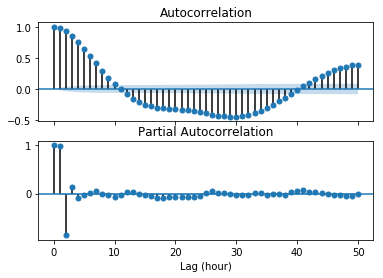

In [7]:
# plot autocorrelation plot and partial autocorrelation plot
def acf_pacf_plots(df, lag = 30):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize = (6, 4))
    
    fig = plot_acf(df, lags = lag, ax = ax1)
    fig = plot_pacf(df, lags = lag, ax = ax2)
    
    ax2.set_xlabel('Lag (hour)')

# plot for training data
acf_pacf_plots(dftrain1.L_T1, lag = 50)

From the above PCF plot, we can see that the first spike is located at somewhere lag *p* = 3. 

Yet it is still difficult to identify the order of lag *q* from above ACF plot. We then make a grid search for finding the order (p, q).

### 1.2 Akaike Information Critera (AIC)
We can check the order by calculating the Akaike Information Critera (AIC) values for the ARMA models. The AIC is a statistical measure which basically quantifies the 1) the goodness of fit and 2) the simplicity/parsimony of the model into a single statistic ([CoolStatsBlog, 2013](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)). The one with the lower AIC is generally “better”, but we're also interested in the “convergence” of the AIC values, i.e., the “good enough” result with the least computation resources.

In [8]:
# perform aic calculations given orders (p, q) and plot the aic grid
def aic_heatmap(df, ps = range(1, 3), qs = range(1, 3), title = 'AIC Grid'):
    aic = [[p, q, ARMA(df, order=(p, q), freq='H').fit().aic]
           for p in ps for q in qs if ((p!=0)|(q!=0))]
    aic = pd.DataFrame(aic, columns = ['p', 'q', 'aic'])
    
    # plot heatmap showing aic values vs (p, q) parameters
    sns.heatmap(aic.pivot('p', 'q', 'aic'), 
                annot = True, fmt='0.1f', linewidths=1)
    plt.title(title)

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


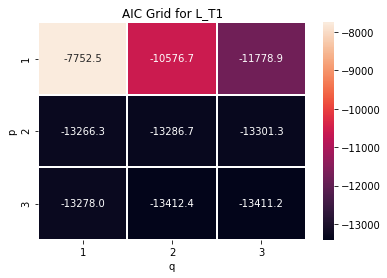

In [169]:
aic_heatmap(dftrain1.L_T1, ps = range(1, 4), qs = range(1, 4), 
            title = 'AIC Grid for L_T1')

### 1.3 Predicting the next value
We can see from the AIC grid graph that higher orders of p and q return a lower AIC score, and that in this grid search, the parameter set of (p, q) = (2, 1) gives a sufficiently good result. After the order of (2, 1), an increase in either p or q gives relatively small improvement in the AIC score. We therefore proceed with an ARMA model with an order of (2, 1).

In [19]:
# train model to predict the next value per time tick
def arma_train_predict(train, test, p, q, stepsize=1, showlog = False):
    history = [x for x in train] # set history (=training data)
    model = ARMA(history, order = (p, q)).fit() # first fit of model with train data
    residual = [x for x in model.resid] # get residuals from train data
    predictions = [] # start prediction

    
    # train model and predict the next time tick
    for t in range(math.ceil(len(test)/stepsize)):
        model = ARMA(history, order = (p, q)).fit()
        vPred = model.forecast(steps = stepsize)[0]
        vReal = test.values[t*stepsize:min((t+1)*stepsize, len(test))]
        # book keeping
        predictions += vPred[:len(vReal)].tolist()
        history += vReal.tolist()
        residual += (vReal - vPred[:len(vReal)]).tolist()            
        if showlog:
            print('i = %i\treal:%0.2f\tpredict: %0.2f\tresidual: %0.2f' % (t, vReal, vPred, vReal-vPred))
    
    # calculate few output statistics
    error = rmse(test.values, np.array(predictions)) # root mean square error
    max_residual = np.abs(residual).max() # max residual
    
    return predictions, error, max_residual

In [120]:
'''
WARNING: The prediction takes a long time to run with stepsize=5. 
         You may try run it with a larger stepsize to speed up the execution (with a less precise result).
'''
# perform arma modeling and predicting
predictions, error, max_residual = arma_train_predict(dftrain1.L_T1, dftrain2.L_T1, p=2, q=1, stepsize=5) #if necessary set showlog = True

print('ARMA resulting root mean square error: %0.3f' % error)

ARMA resulting root mean square error: 0.471
ARMA resulting max residual: 4.693


Text(0, 0.5, 'Water level [meter]')

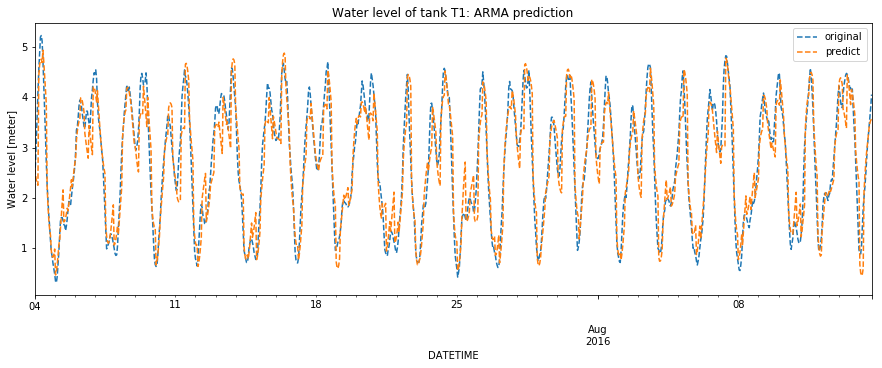

In [162]:
# plot the original predicted results
comparison = pd.DataFrame({'original' : dftrain2.L_T1,
                           'predict' : predictions})
comparison[:1000].plot(style = '--', figsize=(15, 5)) # subset the first 1000hr for clearer visuals
plt.title('Water level of tank T1: ARMA prediction')
plt.ylabel('Water level [meter]')

## 2. Other signals

Four other individual signals are selected for the ARMA task. The results are shown in another notebook file: *Task2_ARMA-other signals*.ipynb. Below is the list of the selected signals:
- Water level of tank T2, *L_T2*
- Water level of tank T3, *L_T3*
- Pressure at junction J302, *P_J302*
- Flowrate at pump PU2, *F_PU2*

From the results we can see that ARMA method **performs better for "continuous" signals such as the water level of tanks**. The method returns larger errors when dealing with more "discretized" signals such as the flowrate of pumps (which is zero when pumps are not activated) and the pressure readings of the junctions.

## 3. Anomaly detection
### 3.1 Setting threshold
The threshold of anomaly detection is hereby set by using training dataset 2.

In [245]:
def plot_error(error_df, threshold = False, title = 'Residual'):
    # plot the results
    fig, ax = plt.subplots(figsize = (15,5))

    for g, df in error_df.groupby('True_class'):
        ax.plot(df.index, df.Residual,
                marker='o', ms=3.5, linestyle='',
                label = 'Attack' if g == 1 else 'Normal')
    if (isinstance(threshold, float))|(isinstance(threshold, int)):
        ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1],
                  linestyle = '--', colors='r', label='Threshold')
    ax.legend(loc = 'upper right')
    fig.autofmt_xdate()
    plt.title(title)
    plt.ylabel("Residual")
    plt.xlabel("Time")

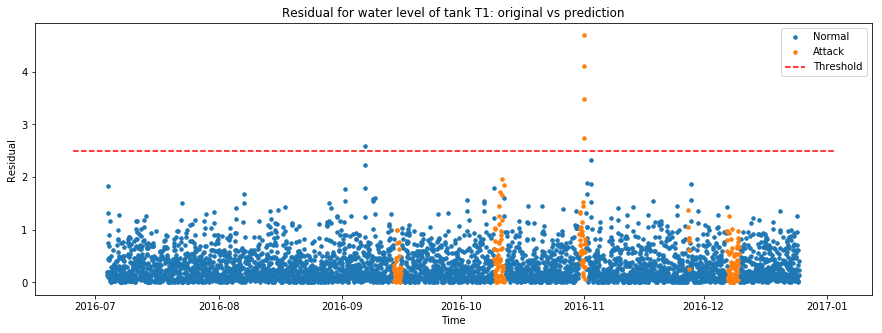

In [166]:
# calculate the residuals
res = np.subtract(dftrain2.L_T1, predictions_T1)
res = abs(res - np.mean(res))
error_df = pd.DataFrame({'Residual': res,
                         'True_class': dftrain2.ATT_FLAG})
plot_error(error_df, threshold=2.5, title='Residual for water level of tank T1: original vs prediction')

From above graph we can see that during the attacks which are related to tank T1 (i.e., on 9-11 October and 29-Oct to 2-Nov), the residuals are indeed larger, although normal data sometime returns large residuals as well. A threshold of a max residual of normal activities shall be sufficient in detecting anomalies.

### 3.2 Evaluation

In [176]:
# train model to predict the next value per time tick
def arma_predict_anomaly(train, test, p, q, learninghr = 100, tolfactor = 1, stepsize = 1, showlog = False):
    history = [x for x in train] # set history (=training data)
    model = ARMA(history, order = (p, q)).fit() # first fit of model with train data
    max_residual = np.abs(model.resid).max() # get max residual from train data
    residual = [max_residual] # initiate an empty list for residuals
    predictions = []
    anomalies = []
        
    # train model and predict the next time tick
    for t in range(math.ceil(len(test)/stepsize)):
        model = ARMA(history, order = (p, q)).fit()
        vPred = model.forecast(steps = stepsize)[0]
        vReal = test.values[t*stepsize:min((t+1)*stepsize, len(test))]
        #print('t: %i\tvPred: %i\tvReal: %i' % (t, len(vPred), len(vReal)))
        if abs(vReal - vPred[:len(vReal)]).max() < max_residual*tolfactor: # if within tolerance, update max residual
            max_residual = np.abs(residual).max()
        elif (t+1)*stepsize < learninghr: # model still learning
            max_residual = np.abs(residual).max()
        else: # residual beyond tolerance = anomaly
            residual_in_step = abs(vReal - vPred[:len(vReal)])
            id_max = np.where(residual_in_step == np.amax(residual_in_step))[0]
            dateAnomaly = test.index[t*stepsize + id_max][0]
            anomalies += [dateAnomaly]
            print('Anomaly detected at %s : real = %0.2f,\tpredict = %0.2f,\tresidual = %0.2f' % 
                    (dateAnomaly, vReal[id_max], vPred[id_max], abs(vReal[id_max]-vPred[id_max])))
        # book keeping
        predictions += vPred[:len(vReal)].tolist()
        history += vReal.tolist()
        residual += (vReal - vPred[:len(vReal)]).tolist()            
        if showlog:
            print('i = %i\treal:%0.2f\tpredict: %0.2f\tresidual: %0.2f' % (t, vReal, vPred, vReal-vPred))

    # output final statistics
    print('Prediction ends!')
    print('The root mean square error for the process is %0.2f.' % rmse(test.values, np.array(predictions)))
    print('The max tolerated residual (for normal data) is %0.2f.' % max_residual)
    return predictions, anomalies, max_residual

### a. Attack ID #8 - contextual anomaly

We demonstrate the detection task using *Attack ID #8* in testing dataset. The attack period is 16/01/2017 09 - 19/01/2017 06 (duration 70 hrs). During this attack activity, the attacker changes L_T3 thresholds, which controls PU4/PU5, and therefore results in low level in L_T3.

In [227]:
# provide attack profile
signal = 'L_T3'
period = ['16/01/17 09', '19/01/17 06'] # period of attack ID #8

# create df for testing
test_ATT8 = pd.DataFrame({signal : dftest[signal],
                          'ATT_FLAG' : np.zeros(len(dftest[signal]))}) # assign dummy label

# get the index of the slice of data at given period
id_attack = [int(np.where(dftest.index == pd.to_datetime(time, format = '%d/%m/%y %H'))[0]) 
             for time in period]
test_ATT8.loc[id_attack[0]:id_attack[1], 'ATT_FLAG'] = 1 # label the attacks

Text(0, 0.5, 'water level [meter]')

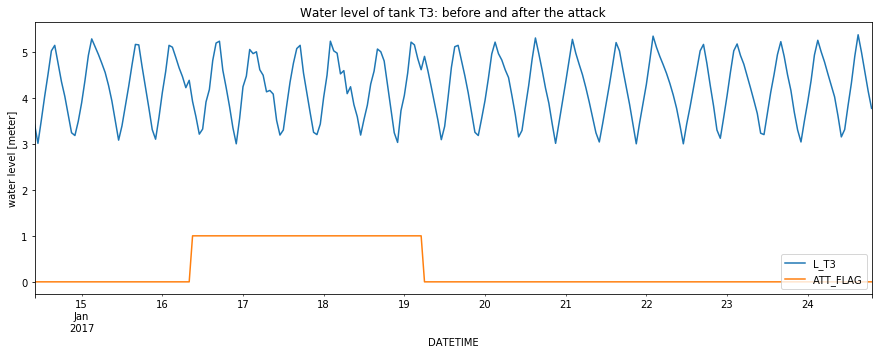

In [240]:
# plot the attack profile
test_ATT8[250:500].plot(figsize=(15, 5)) # subset the first 1000hr for clearer visuals
plt.legend(loc='lower right')
plt.title('Water level of tank T3: before and after the attack')
plt.ylabel('water level [meter]')

From the attack profile, we can see that L_T3 presents a **contextual anomaly** in the end of the attack period.

In [241]:
# define train and test data (for a single signal)
test = dftest[signal]
train = dftrain1[signal]

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


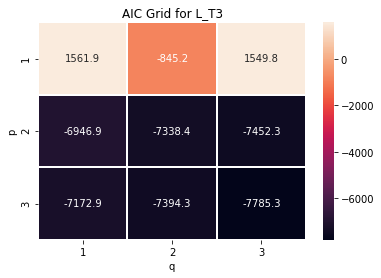

In [242]:
# double-check that the ARMA(p, q) model is sufficiently good
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for {}'.format(signal))

In [243]:
# predict and detect anomanly
predictions, anomalies, max_residual = arma_predict_anomaly(train, test, p=2, q=2, stepsize=5) #if necessary set showlog = True

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Prediction ends!
The root mean square error for the process is 0.24.
The max tolerated residual (for normal data) is 1.01.


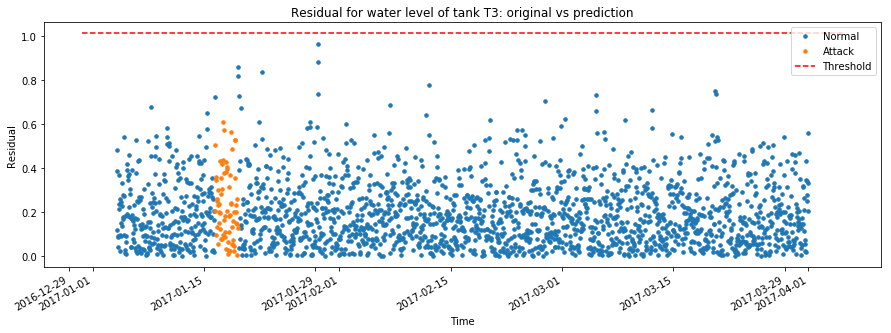

In [246]:
# calculate the residuals
res = np.subtract(test, predictions)
res = abs(res - np.mean(res))
error_df = pd.DataFrame({'Residual': res,
                         'True_class': test_ATT8.ATT_FLAG})
plot_error(error_df, max_residual, title='Residual for water level of tank T3: original vs prediction')

The ARMA algorithm failed to detect this contextual anomaly of attack ID #8.

### b. Attack ID #9 and #12 - collective anomaly

We demonstrate the detection task using *Attack ID #9 and #12* in testing dataset. The attack period is 30/01/17 08 - 02/02/17 00 (duration 65 hrs) and 24/02/17 05 - 28/02/17 08 (duration 100 hrs) respectively. Both attacks are related to tank T2. During this attack activity, the attacker changes L_T2 readings, which controls valve V2, and therefore results in overflw in L_T2.

In [251]:
def string_to_id(time, dftest):
    return int(np.where(dftest.index == pd.to_datetime(time, format = '%d/%m/%y %H'))[0])

In [256]:
# provide attack profile
signal = 'L_T2'
period = [['30/01/17 08', '02/02/17 00'], # period of attack ID #9
          ['24/02/17 05', '28/02/17 08']] # period of attack ID #12

# create df for testing
test_ATT9and12 = pd.DataFrame({signal : dftest[signal],
                               'ATT_FLAG' : np.zeros(len(dftest[signal]))}) # assign dummy label

# get the index of the slice of data at given period
id_attack = [[string_to_id(starttime, dftest), string_to_id(endtime, dftest)] 
             for starttime, endtime in period]
for ids in id_attack:
    test_ATT9and12.loc[ids[0]:ids[1], 'ATT_FLAG'] = 1 # label the attacks

Text(0, 0.5, 'water level [meter]')

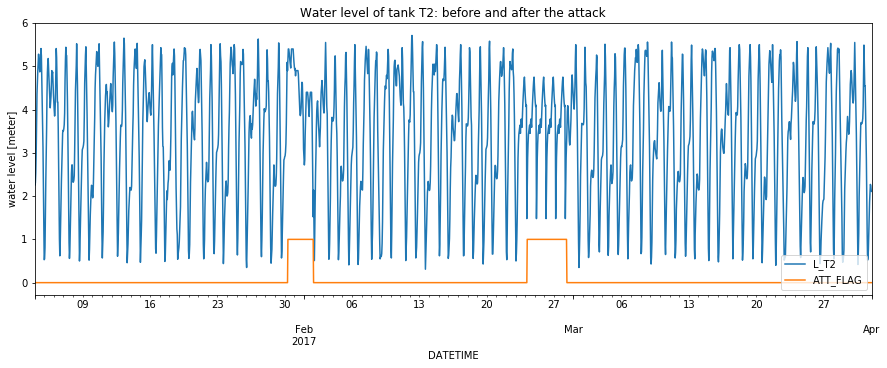

In [257]:
# plot the attack profile
test_ATT9and12.plot(figsize=(15, 5)) # subset the first 1000hr for clearer visuals
plt.legend(loc='lower right')
plt.title('Water level of tank T2: before and after the attack')
plt.ylabel('water level [meter]')

From the attack profile, we can see that L_T2 presents a **collective anomaly** in the end of the attack period.

In [258]:
# define train and test data (for a single signal)
test = dftest[signal]
train = dftrain1[signal]

C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


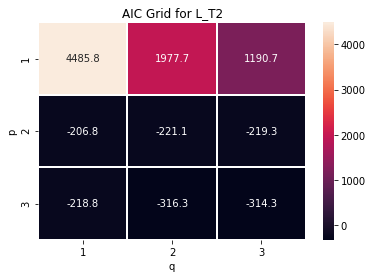

In [259]:
# double-check that the ARMA(p, q) model is sufficiently good
aic_heatmap(train, ps = range(1, 3+1), qs = range(1, 3+1), 
            title = 'AIC Grid for {}'.format(signal))

In [260]:
# predict and detect anomanly
predictions, anomalies, max_residual = arma_predict_anomaly(train, test, p=2, q=1, stepsize=5) #if necessary set showlog = True

Anomaly detected at 2017-01-12 07:00:00 : real = 5.56,	predict = 3.25,	residual = 2.31


C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Anomaly detected at 2017-01-16 06:00:00 : real = 5.50,	predict = 3.17,	residual = 2.33


C:\Users\Hsin\.conda\envs\deeplearning\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Anomaly detected at 2017-01-27 06:00:00 : real = 5.63,	predict = 3.25,	residual = 2.38
Anomaly detected at 2017-01-29 14:00:00 : real = 2.30,	predict = 4.74,	residual = 2.44
Anomaly detected at 2017-02-04 14:00:00 : real = 0.53,	predict = 3.03,	residual = 2.50
Anomaly detected at 2017-02-27 04:00:00 : real = 1.48,	predict = 4.07,	residual = 2.59
Anomaly detected at 2017-02-28 08:00:00 : real = 3.49,	predict = -2.65,	residual = 6.14
Prediction ends!
The root mean square error for the process is 0.82.
The max tolerated residual (for normal data) is 6.14.


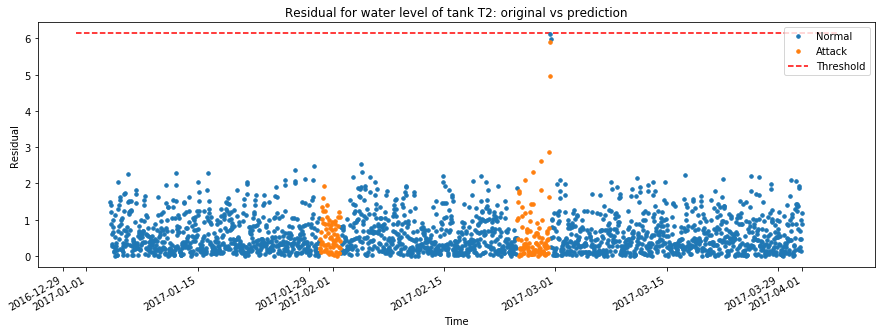

In [261]:
# calculate the residuals
res = np.subtract(test, predictions)
res = abs(res - np.mean(res))
error_df = pd.DataFrame({'Residual': res,
                         'True_class': test_ATT9and12.ATT_FLAG})
plot_error(error_df, max_residual, title='Residual for water level of tank T2: original vs prediction')

The ARMA model succeeded in detecting attack ID #12, but as it continues to take in the sequence of anomalous data points, the model increase its threshold, which is not desired.

## 4. Conclusion

For anomaly detection, the threshold can be set as the max residual for normal data (with a multiplier of some 1.05 or 1.1, if necessary). ARMA model performs well when dealing with "continuous" data; in this case, the water level of tanks.